In [76]:
from typing import Annotated, TypedDict
import operator
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# 상태 타입 정의
class State(TypedDict):
    aggregate: Annotated[list, operator.add]  # 결과를 누적하는 리스트
    query: str  # 사용자 질의
    context: str  # 검색 결과나 컨텍스트
    sql: str  # 생성된 SQL 쿼리

# 검색 필요 여부 확인 노드 (상태를 반환하는 노드 함수)
def route_node(state: State):
    # 노드 함수는 상태 변화만 처리하고 아무것도 반환하지 않거나 빈 딕셔너리 반환
    print(f"Processing query: {state.get('query', '')}")
    return {}  # 또는 상태 업데이트가 필요하면 업데이트된 필드를 포함한 딕셔너리

# 라우팅을 위한 함수 (문자열 경로를 반환하는 라우팅 함수)
def route_to_search_or_skip(state: State) -> str:
    query = state.get("query", "")
    if "[SEARCH]" in query:
        print("Found [SEARCH] in query, will perform web search")
        return "do_search"
    else:
        print("No [SEARCH] in query, will skip web search")
        return "skip_search"

# 웹 검색 수행 노드
def tavily_search(state: State):
    query = state.get("query", "").replace("[SEARCH]", "").strip()
    print(f"Performing web search for: {query}")
    # 실제로는 여기서 Tavily API 호출
    search_results = f"Simulated search results for: {query}"
    return {"context": search_results}

# SQL 생성 노드 - 검색 결과가 있으면 활용
def sql_agent(state: State):
    query = state.get("query", "").replace("[SEARCH]", "").strip()
    context = state.get("context", "")
    
    print(f"Generating SQL for query: {query}")
    if context:
        print(f"Using context: {context}")
    
    # 실제로는 여기서 LLM을 사용하여 SQL 생성
    sql = f"SELECT * FROM table WHERE condition -- Based on: {query}"
    return {"sql": sql, "aggregate": ["SQL generated"]}

# 그래프 생성
# 그래프 생성
builder = StateGraph(State)

# 노드 추가
builder.add_node("route", route_node)  # 노드 함수 사용
builder.add_node("tavily_search", tavily_search)
builder.add_node("sql_agent", sql_agent)

# 경로 설정
builder.add_edge(START, "route")

# 조건부 경로 설정 - 라우팅 함수 사용
builder.add_conditional_edges(
    "route",
    route_to_search_or_skip,  # 라우팅 함수 사용
    {
        "do_search": "tavily_search",
        "skip_search": "sql_agent"
    }
)

# 나머지 코드는 동일
builder.add_edge("tavily_search", "sql_agent")
builder.add_edge("sql_agent", END)

# 그래프 컴파일
graph = builder.compile()

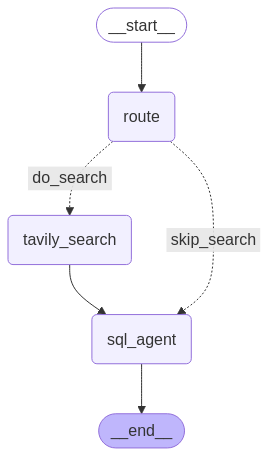

In [77]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [79]:

# 테스트 실행
inputs = {
    "query": "회사의 2023년 매출 데이터를 보여줘",
    "aggregate": []
}
result = graph.invoke(inputs)
print("\n","-"*100,"\n")
inputs_with_search = {
    "query": "[SEARCH] 2023년 글로벌 반도체 시장 규모와 회사별 점유율을 보여줘",
    "aggregate": []
}
result_with_search = graph.invoke(inputs_with_search)

Processing query: 회사의 2023년 매출 데이터를 보여줘
No [SEARCH] in query, will skip web search
Generating SQL for query: 회사의 2023년 매출 데이터를 보여줘

 ---------------------------------------------------------------------------------------------------- 

Processing query: [SEARCH] 2023년 글로벌 반도체 시장 규모와 회사별 점유율을 보여줘
Found [SEARCH] in query, will perform web search
Performing web search for: 2023년 글로벌 반도체 시장 규모와 회사별 점유율을 보여줘
Generating SQL for query: 2023년 글로벌 반도체 시장 규모와 회사별 점유율을 보여줘
Using context: Simulated search results for: 2023년 글로벌 반도체 시장 규모와 회사별 점유율을 보여줘


In [15]:
url = "https://grapeman.duckdns.org/static/audio/1742640943.m4a"

In [16]:
import requests

response = requests.get(url)

with open("test.m4a", "wb") as f:
    f.write(response.content)

In [14]:
import requests

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}
url = "https://grapeman.duckdns.org/static/audio/1742640630.m4a"

response = requests.get(url, headers=headers)

print("응답 코드:", response.status_code)

if response.status_code == 200:
    with open("test_download.m4a", "wb") as f:
        f.write(response.content)
        print("✅ 저장 완료!")
else:
    print("❌ 다운로드 실패:", response.text)


응답 코드: 403
❌ 다운로드 실패: <html>
<head><title>403 Forbidden</title></head>
<body>
<center><h1>403 Forbidden</h1></center>
<hr><center>nginx/1.18.0 (Ubuntu)</center>
</body>
</html>

